In [2]:
import sys
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pysindy as ps

warnings.filterwarnings("ignore")


from sklearn.decomposition import PCA

# RL libraries
sys.path.append('resources')  # add source directoy to path
from resources import bandits

from labrotation.sampling import generate_libraries, sample_custom_library
from labrotation.agents import dict_agents, get_q

In [3]:
MODEL_NUM = 100

In [4]:
# agent parameters
agent_kw = 'basic'  # basic, quad_q 
gen_alpha = .25 #@param
gen_beta = 5 #@param
forgetting_rate = 0.1 #@param
perseveration_bias = 0.  #@param
# environment parameters
non_binary_reward = False #@param
n_actions = 2 #@param
sigma = .1  #@param

# experiement parameters
n_trials_per_session = 200  #@param
n_sessions = 220  #@param

# setup
environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_rewards=non_binary_reward)
agent = dict_agents[agent_kw](gen_alpha, gen_beta, n_actions, forgetting_rate, perseveration_bias)  

# dataset_train, experiment_list_train = bandits.create_dataset(
#     agent=agent,
#     environment=environment,
#     n_trials_per_session=n_trials_per_session,
#     n_sessions=n_sessions)

dataset_test, experiment_list_test = bandits.create_dataset(
    agent=agent,
    environment=environment,
    n_trials_per_session=n_trials_per_session,
    n_sessions=1)

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# SINDy library

custom_lib_functions = [
    # sub-library which is always included
    lambda q, c, r: 1,
    lambda q, c, r: q,
    lambda q, c, r: r,
    lambda q, c, r: np.power(q, 2),
    lambda q, c, r: q * r,
    lambda q, c, r: np.power(r, 2),
    # sub-library if the possible action was chosen
    lambda q, c, r: c,
    lambda q, c, r: c * q,
    lambda q, c, r: c * r,
    lambda q, c, r: c * np.power(q, 2),
    lambda q, c, r: c * q * r,
    lambda q, c, r: c * np.power(r, 2),
]

custom_lib_names = [
    # sub-library which is always included
    '1',
    'q',
    'r',
    'q^2',
    'q*r',
    'r^2',
    # sub-library if the possible action was chosen
    'c',
    'c*q',
    'c*r',
    'c*q^2',
    'c*q*r',
    'c*r^2',
]

# make SINDy library
custom_lib = ps.CustomLibrary(
    custom_lib_functions,
    custom_lib_names,
)

In [6]:
from labrotation.agents import AgentSindy, make_sindy_data

# sindy hyperparameter
threshold = 0.01
dt = 1

# sampling hyperparameters
rng = np.random.default_rng()

# loop for sampling random models, fitting SINDy and computing the mean squared error between the coefficients
qs = []
mse_models = []
for i in range(MODEL_NUM):
    # sample random model
    lib, lib_names, w, mask = sample_custom_library(custom_lib_functions, custom_lib_names, rng.laplace)
    
    # define update rule with global variables: library, weights_sampled
    # update function for sampled model
    
    def update_function_sampled(q, c, r):
        return np.sum([l(q, c, r) * w_l for l, w_l in zip(lib, w)])
    
    # setup a SINDy model with the sampled library weights
    sampled_groundtruth = AgentSindy(alpha=0, beta=gen_beta, n_actions=n_actions)
    sampled_groundtruth.set_update_rule(update_function_sampled)
    
    try:
        # generate data for the sampled model
        dataset_sampled, experiment_list_sampled = bandits.create_dataset(
            agent=sampled_groundtruth,
            environment=environment,
            n_trials_per_session=n_trials_per_session,
            n_sessions=10
            )
    except:
        print("Error in creating dataset (Probably NaN for choice_probs). Continue with next library.")
        continue
    
    x_train, control, feature_names = make_sindy_data(experiment_list_sampled, sampled_groundtruth, get_choices=True)
    # scale q-values between 0 and 1
    x_max = np.max(np.stack(x_train, axis=0))
    x_min = np.min(np.stack(x_train, axis=0))
    x_train = [(x - x_min) / (x_max - x_min) for x in x_train]
    # replace NaN values with 0
    x_train = [np.nan_to_num(x) for x in x_train]
    
    # fit a SINDy model to the data of the sampled model
    datasindy = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold, verbose=True, alpha=0.1),
        feature_library=custom_lib,
        discrete_time=True,
        feature_names=feature_names,
    )
    datasindy.fit(x_train, t=dt, u=control, ensemble=False, library_ensemble=False, multiple_trajectories=True)
    # datasindy.print()
    # set new sindy update rule and synthesize new dataset
    def update_rule_sindy(q, choice, reward):
        return datasindy.simulate(q, t=2, u=np.array([choice, reward]).reshape(1, 2))[-1]
    datasindyagent = AgentSindy(alpha=0, beta=gen_beta, n_actions=n_actions)
    datasindyagent.set_update_rule(update_rule_sindy, datasindy.equations)

    # get q-values for a specific trajectory for the sampled model for later PCA
    q = get_q(experiment_list_test[0], sampled_groundtruth)[0]
    # scale q-values between 0 and 1
    x_max = np.max(np.stack(q, axis=0))
    x_min = np.min(np.stack(q, axis=0))
    q = [(x - x_min) / (x_max - x_min) for x in q]
    # replace NaN values with 0
    q = [np.nan_to_num(x) for x in q]
    qs.append(q)

    # compute the mean squared error between the sampled model coefficients and the SINDy model coefficients
    sindy_coeffs = datasindy.coefficients()
    sampled_coeffs = np.zeros_like(sindy_coeffs)
    sampled_coeffs[0, mask] = w
    mse_models.append(np.mean((sindy_coeffs - sampled_coeffs) ** 2))

Shape of Q-Values is: (20, 200, 1)
Shape of control parameters is: (20, 200, 2)
Feature names are: ['q', 'c', 'r']
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 4.6211e-03 ... 1.2924e-01 ...         10 ... 1.3386e-01
         1 ... 3.8047e-03 ... 1.2928e-01 ...         10 ... 1.3308e-01
Shape of Q-Values is: (20, 200, 1)
Shape of control parameters is: (20, 200, 2)
Feature names are: ['q', 'c', 'r']
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.3966e-04 ... 5.2916e-02 ...          5 ... 5.3056e-02
         1 ... 3.8847e-06 ... 5.2947e-02 ...          5 ... 5.2951e-02
Shape of Q-Values is: (20, 200, 1)
Shape of control parameters is: (20, 200, 2)
Feature names are: ['q', 'c', 'r']
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.8522e-02 ... 4.2068e-01 ...          5 ... 4.3920e-01
         1 .

In [7]:
# q_array = np.array(qs)
# choice_probs_array = np.array(choice_probs)
# complexities = [model.optimizer.complexity for model in datasindy_fits]

In [10]:
# filter absurdly high mse values
print(f"Number of models before filtering: {len(qs)}")
mse_models_old = mse_models

threshold_mse = 0.5
mse_models = np.array(mse_models)
mask = mse_models < threshold_mse
qs = np.array(qs)[mask]
mse_models = mse_models[mask]

print(f"Number of models after filtering: {len(qs)}")

Number of models before filtering: 73
Number of models after filtering: 73


In [11]:
pca = PCA(3)
qs_array = np.stack([q_model[:, 0] for q_model in qs], axis=0)
res = pca.fit_transform(qs_array)

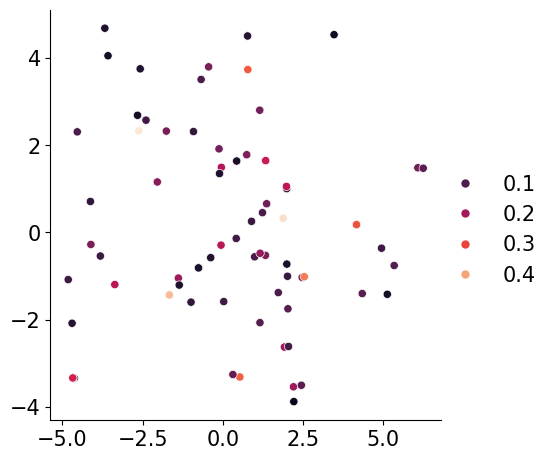

In [12]:
g = sns.relplot(x=res[:, 0], y=res[:, 1], hue=mse_models, palette=sns.color_palette("rocket", as_cmap=True))  # style=complexities

In [18]:
from utils.interactive_plots import interactive_scatter_3dplot

interactive_scatter_3dplot(res[:, 0], res[:, 1], res[:, 2], mse_models, "3D PCA with MSE")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed